# **CS/CE 457/464 - Homework Assignment 9: Time Series Analysis**

### Breeha Qasim 08283

###### bq08283@st.habib.edu.pk

In [4]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore") #optional
plt.style.use('fivethirtyeight') #optional
import pandas as pd
import statsmodels.api as sm
import matplotlib
from pylab import rcParams
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [6]:
data = pd.read_csv('karachi-weather-2021-2023.csv', parse_dates= ['datetime'])
data = data.set_index('datetime')
data.head()

,temp
datetime,
2021-01-01,15.0
2021-01-02,15.4
2021-01-03,15.6
2021-01-04,16.3
2021-01-05,17.1


## Q1

In [9]:
data_weekly = data['temp'].resample('W').mean()
data_weekly

datetime
2021-01-03    15.333333
2021-01-10    16.028571
2021-01-17    17.085714
2021-01-24    19.457143
2021-01-31    17.800000
                ...    
2023-04-02    26.414286
2023-04-09    27.328571
2023-04-16    27.628571
2023-04-23    29.414286
2023-04-30    29.700000
Freq: W-SUN, Name: temp, Length: 122, dtype: float64

##### **^Explanation/Reasoning:** The output, which displays the weekly average temperatures from January 2021 to April 2023, demonstrates a slow rise and fall in temperature over time. This chart points to seasonal patterns with clear warming and cooling spikes across time.

## Q2

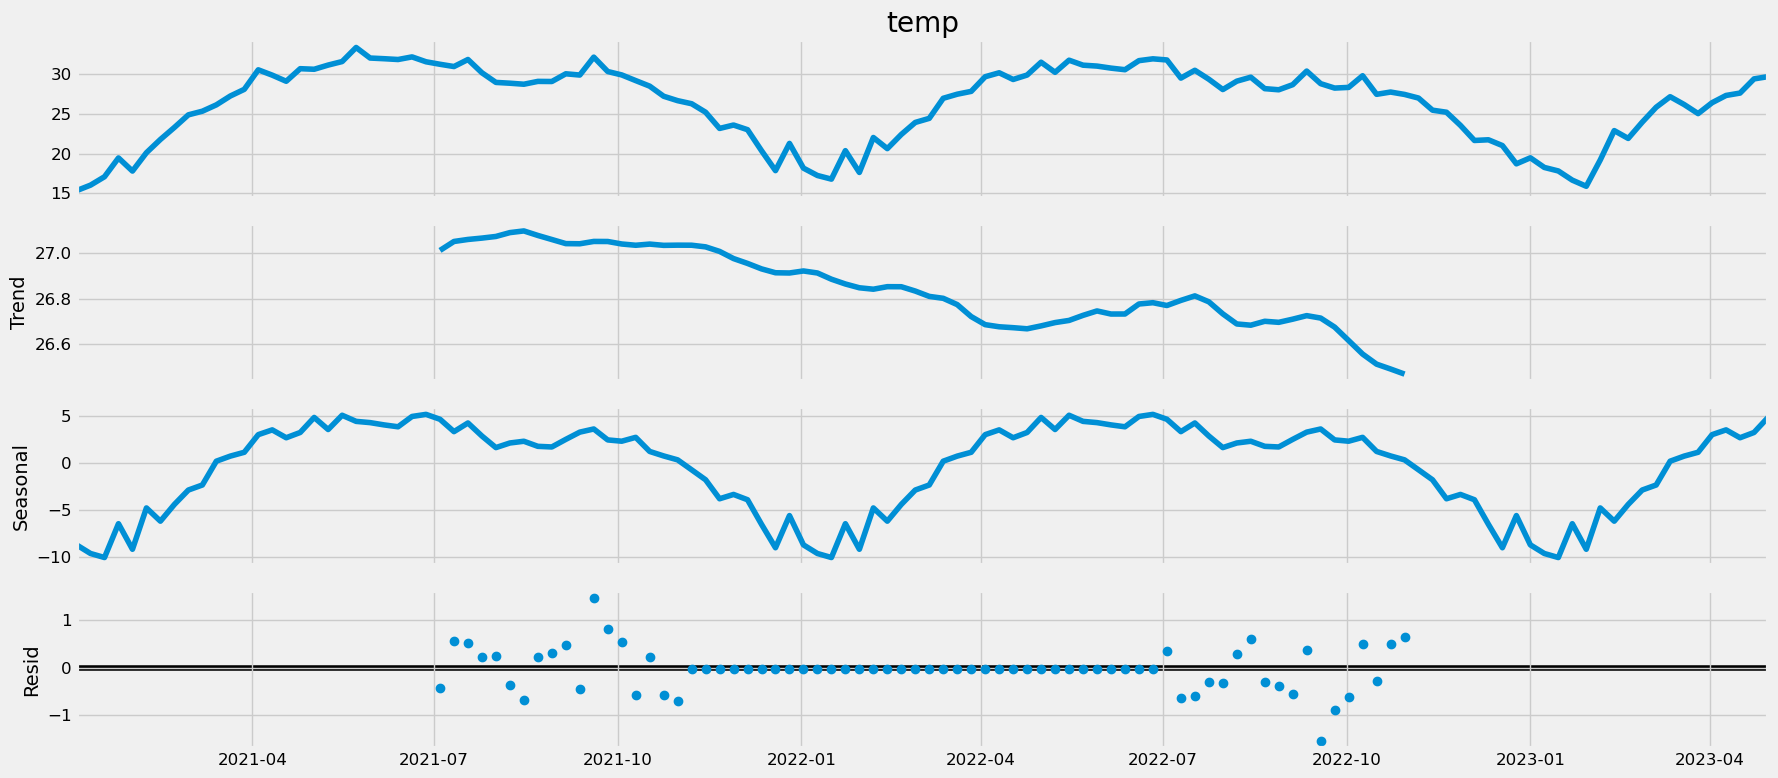

In [13]:
decomposition = sm.tsa.seasonal_decompose(data_weekly, model='additive')
rcParams['figure.figsize'] = 18, 8
fig = decomposition.plot()
plt.show()

##### **^Explanation/Reasoning:** The temperature time series is broken down into trend, seasonal, and residual components by the graphic. It has distinct periodic seasonal patterns, a general downward trend from late 2021 to early 2022, and little residual noise, all of which point to well-explained data behaviour.

## Q3

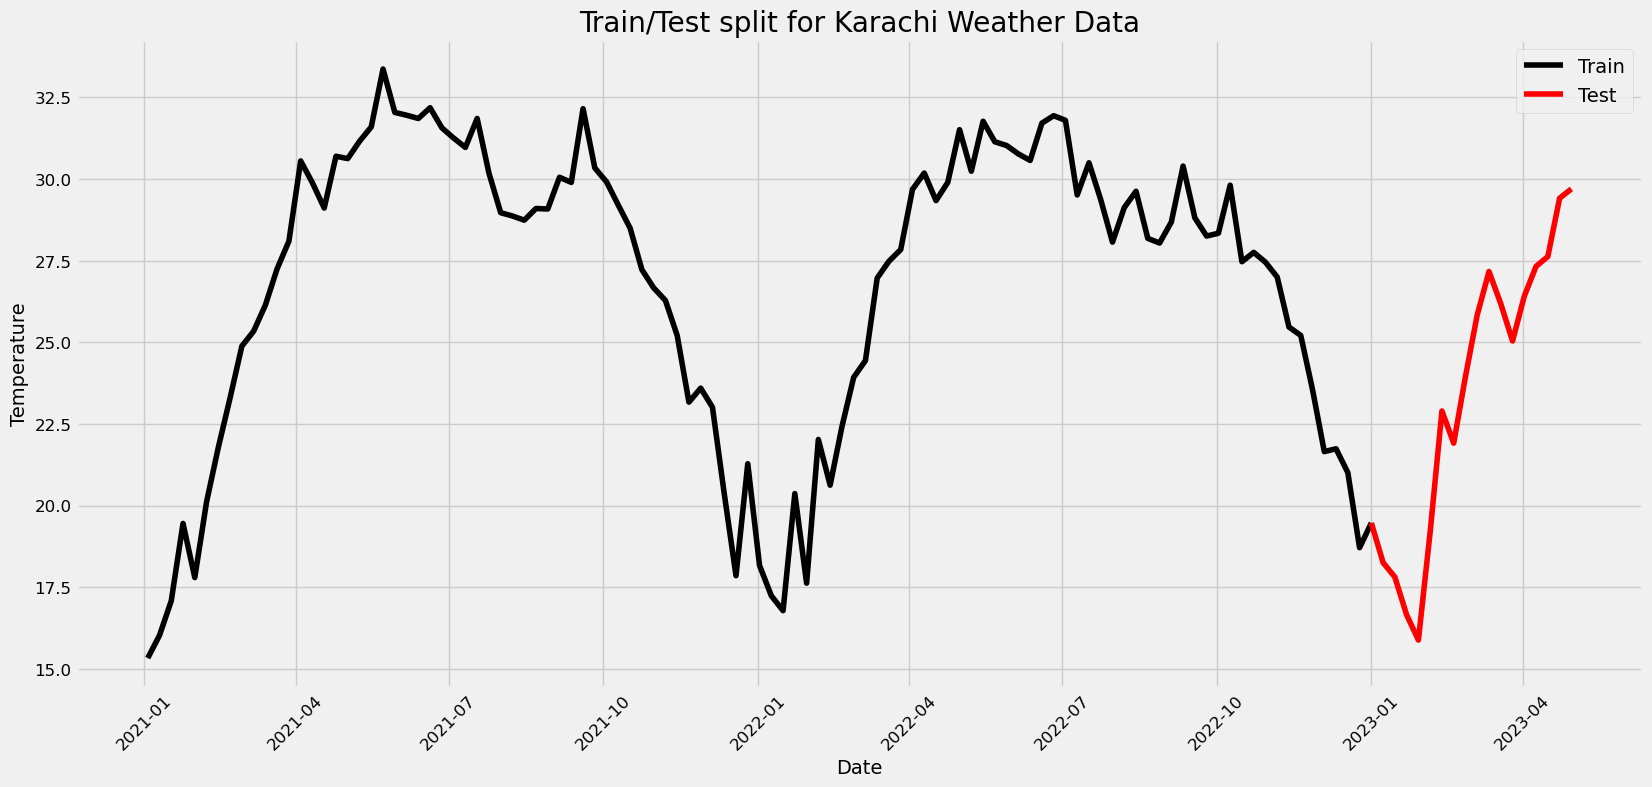

In [16]:
train = data_weekly[data_weekly.index <= pd.to_datetime("2023-01-01", format='%Y-%m-%d')]
test = data_weekly[data_weekly.index >= pd.to_datetime("2023-01-01", format='%Y-%m-%d')]

plt.plot(train, color="black", label='Train')
plt.plot(test, color="red", label='Test')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Karachi Weather Data")
plt.legend()
plt.show()

##### **^Explanation/Reasoning:** With the test set in red and the training set in black, the plot depicts the train-test split for Karachi weather data. The test set represents future forecasts beyond the training period, enabling model evaluation. The data shows a distinct temperature trend with swings over time.

## Q4

Best RMSE: 3.06



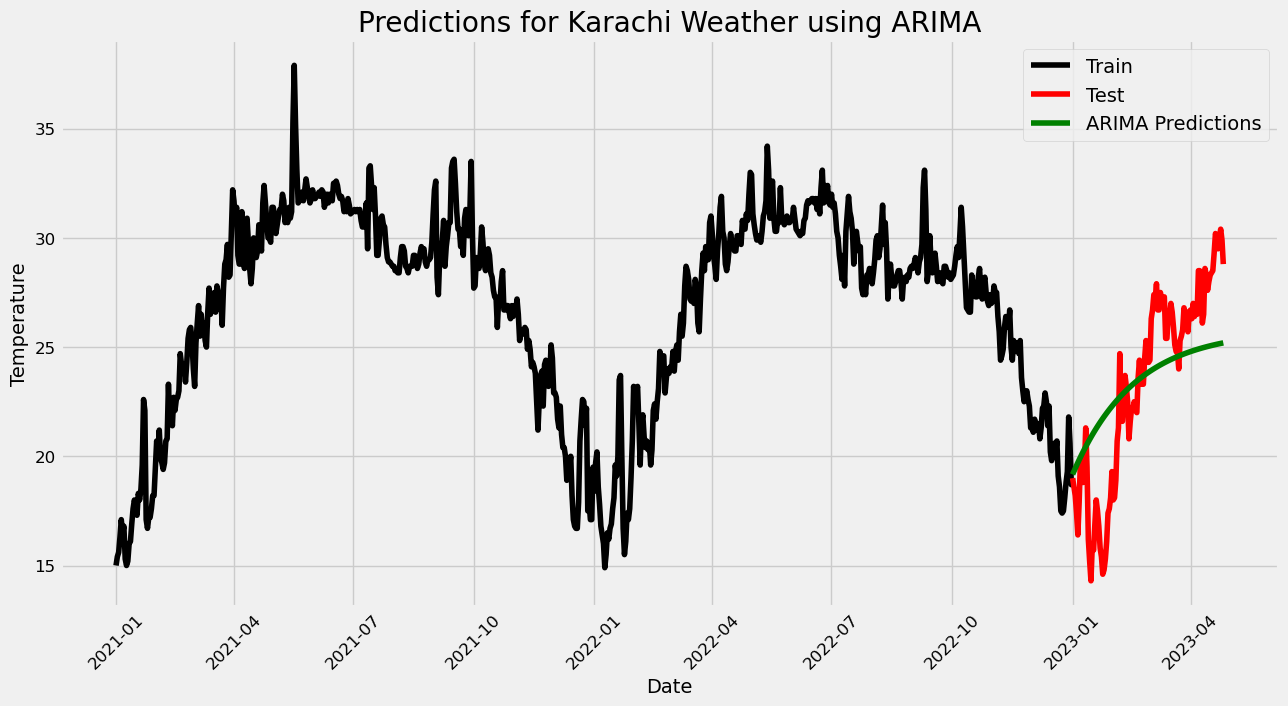

In [66]:
def arima_model_evaluation(train_data, test_data, p, d, q):
    
    model = ARIMA(train_data, order=(p, d, q))
    
    model_fit = model.fit()

    #Test set prediction
    forecast = model_fit.get_forecast(steps=len(test_data.index)) 
    forecast_df = forecast.conf_int(alpha=0.05)
    forecast_df['Predictions'] = model_fit.predict(start=forecast_df.index[0], end=forecast_df.index[-1])
    #for testing prediction plotting purposes
    forecast_df.index = test_data.index
    predictions = forecast_df['Predictions']

    rmse = np.sqrt(mean_squared_error(test_data.values, predictions))
    
    return rmse, predictions

best_rmse = float('inf')
best_combination = None
best_predictions = None

parameter_combinations = list(itertools.product([0, 1, 2], repeat=3))

for params in parameter_combinations:
    p, d, q = params
    rmse, predictions = arima_model_evaluation(train, test, p, d, q)
    if rmse < best_rmse:
        best_rmse = rmse
        best_combination = params
        best_predictions = predictions

print(f'Best RMSE: {best_rmse:.2f}\n')

plt.figure(figsize=(14, 7))
plt.plot(train, color="black", label='Train')
plt.plot(test, color="red", label='Test')
plt.plot(best_predictions, color='green', label='ARIMA Predictions')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Predictions for Karachi Weather using ARIMA")
plt.legend()
plt.show()

results_df = pd.DataFrame({
    'Datetime': best_predictions.index,
    'Predicted_Temperature': best_predictions.values,
    'Algorithm': 'ARIMA'
})

##### **^Explanation/Reasoning:** Because of its lowest RMSE of 3.06, which shows that it does a respectable job of forecasting temperature trends, this ARIMA model with parameters (1, 0, 1) was chosen as the best match. The plot demonstrates that while the model successfully depicts the overall upward trend during the 2023 test period, it is unable to fully replicate the unpredictability of the actual temperatures. The amplitude of fluctuations is somewhat underestimated, indicating the model's limitations in modelling complicated variations, even while it accurately forecasts the direction of temperature changes. This output shows that the model works well for simple forecasting, but it might require more components or fine-tuning to properly capture seasonality or abrupt changes.

## Q5

SARIMAX: (1, 1, 1)x(0, 1, 1, 12) - AIC: 1990.3169521122736


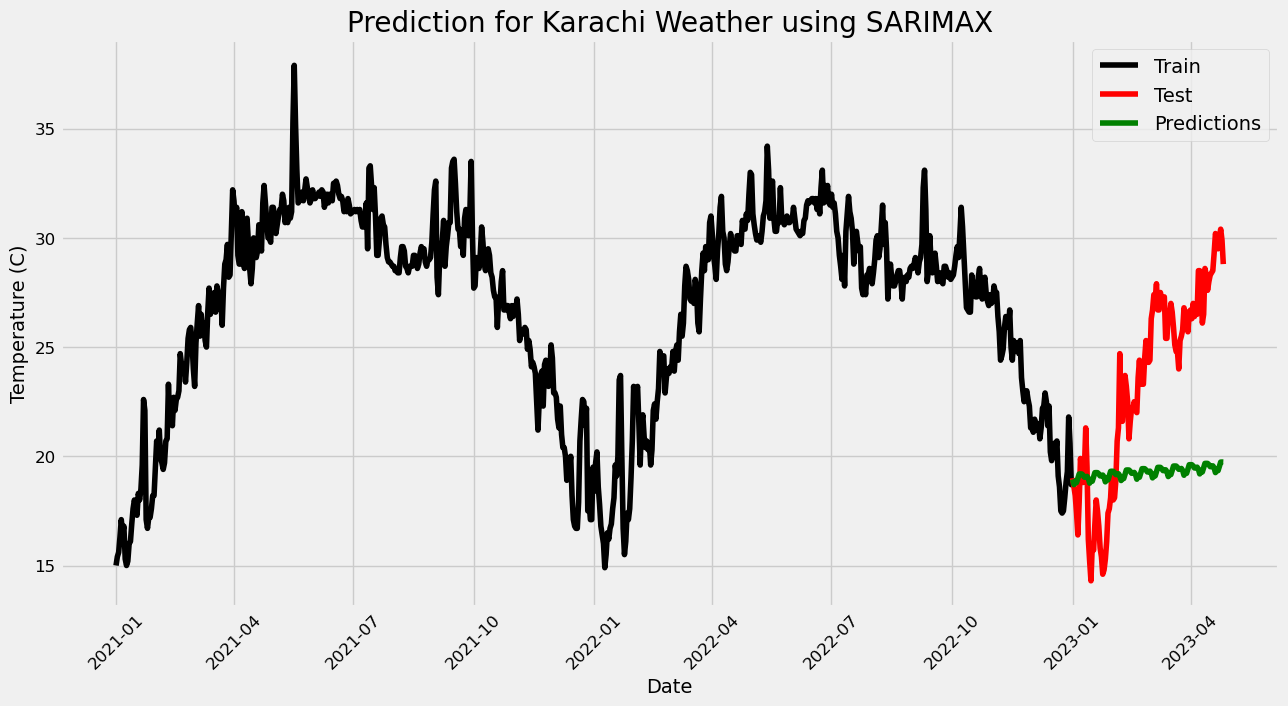

RMSE: 5.914436995939888


In [94]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in itertools.product(p, d, q)]

best_aic = float('inf')
best_pdq = None
best_seasonal_pdq = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(train, 
                            order=param, 
                            seasonal_order=param_seasonal, 
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except Exception as e:
            continue

print(f'SARIMAX: {best_pdq}x{best_seasonal_pdq} - AIC: {best_aic}')

# Use optimal parameters from above with lowest AIC
SARIMAXmodel = SARIMAX(train, order=best_pdq, seasonal_order=best_seasonal_pdq)
SARIMAXmodel = SARIMAXmodel.fit()

#Test set prediction
y_pred = SARIMAXmodel.get_forecast(steps=len(test))
y_pred_df = y_pred.conf_int(alpha=0.05)
y_pred_df["Predictions"] = SARIMAXmodel.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])

#for testing prediction plotting purposes
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"]

plt.figure(figsize=(14, 7))
plt.plot(train, color='black', label='Train')
plt.plot(test, color='red', label='Test')
plt.plot(y_pred_out, color='green', label='Predictions')
plt.xlabel('Date')
plt.ylabel('Temperature (C)')
plt.title('Prediction for Karachi Weather using SARIMAX')
plt.legend()
plt.xticks(rotation=45)
plt.show()

sar_df = pd.DataFrame({
    'Datetime': y_pred_df.index,
    'Predicted_Temperature': y_pred_df['Predictions'].values,
    'Algorithm': 'SARIMAX'
})

arma_rmse = np.sqrt(mean_squared_error(test.values, y_pred_df['Predictions']))
print("RMSE:", arma_rmse)

##### **^Explanation/Reasoning:** The temperature data's general trend is captured by the model, which displays a consistent increase and fall consistent with the training set's seasonal trends. However, as the red line illustrates, the projections have a tendency to flatten out and fall short of capturing the dramatic rise in temperatures over the test period. This implies that the SARIMAX model may have trouble with short-term swings or sudden shifts, even while it can capture long-term patterns and seasonality, resulting in an RMSE of about 5.91. Future predictions from the model may be more accurate if the parameters are adjusted or if more exogenous factors are used.

## Q6

In [100]:
p = d = q = range(0, 2)
P = Q = D = range(1, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, Q, D))]

In [102]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('SARIMAX{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMAX(0, 0, 0)x(1, 1, 1, 12)12 - AIC:3063.5665389242067
SARIMAX(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2535.0139828848933
SARIMAX(0, 1, 0)x(1, 1, 1, 12)12 - AIC:2026.1267158717721
SARIMAX(0, 1, 1)x(1, 1, 1, 12)12 - AIC:1998.4957453342356
SARIMAX(1, 0, 0)x(1, 1, 1, 12)12 - AIC:2020.6075525457682
SARIMAX(1, 0, 1)x(1, 1, 1, 12)12 - AIC:1992.7073635196916
SARIMAX(1, 1, 0)x(1, 1, 1, 12)12 - AIC:2001.2429506612489
SARIMAX(1, 1, 1)x(1, 1, 1, 12)12 - AIC:2016.076114627471


##### To find optimal parameter for SARIMA we'll pick the lowest AIC which in our case is SARIMAX(1, 0, 1)x(1, 1, 1, 12)12 - AIC:1992.7073635196916


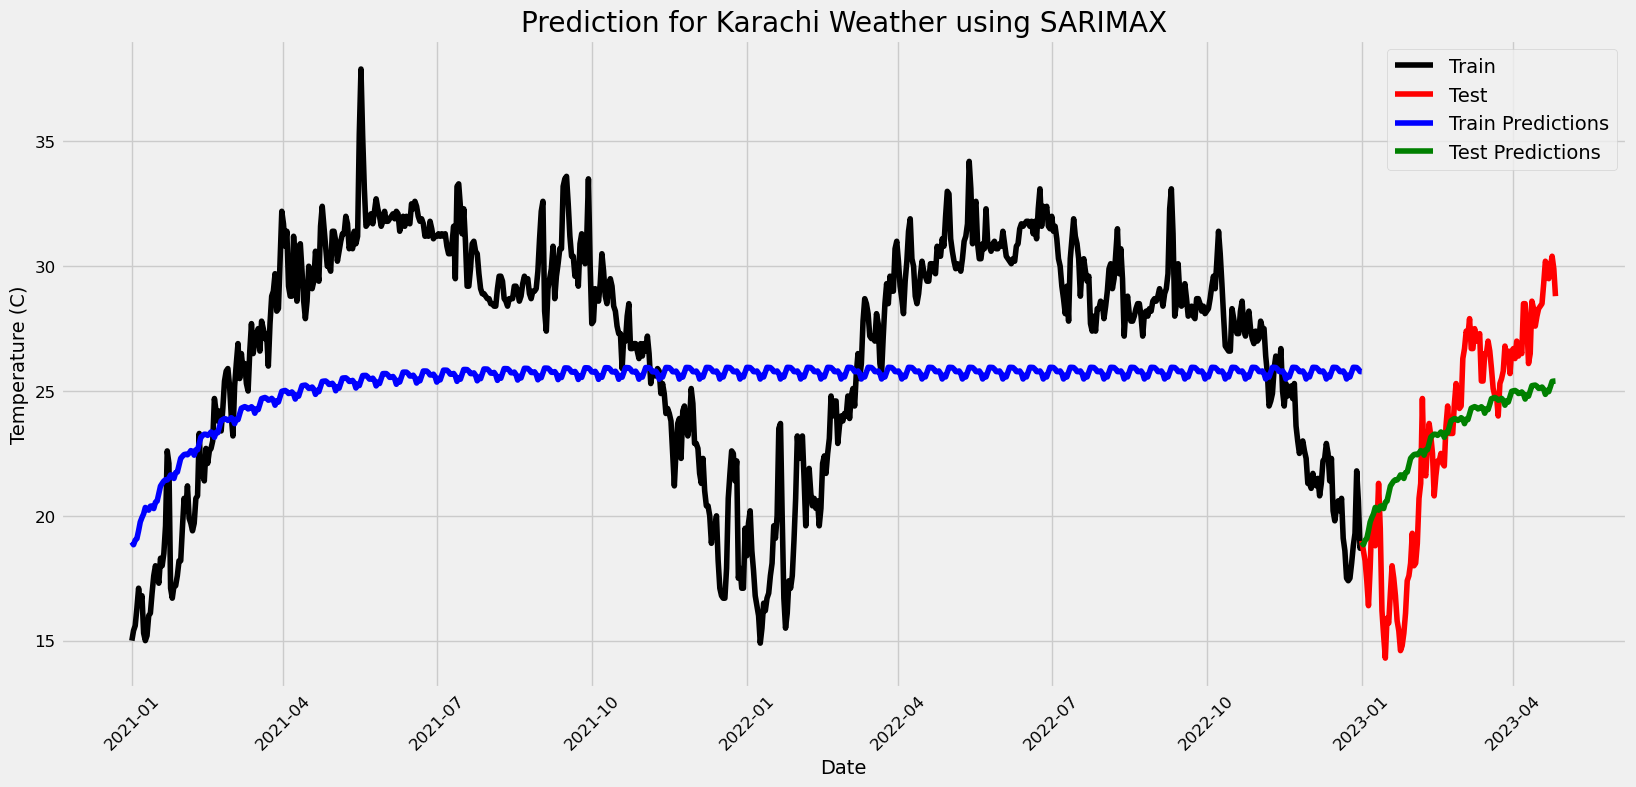

RMSE:  2.9962192025670653


In [107]:
SARIMAXmodel = SARIMAX(train, order=(1,0,1),seasonal_order=(1, 1, 1, 12)) 
SARIMAXmodel = SARIMAXmodel.fit()

#Train set prediction
y_pred_train = SARIMAXmodel.get_forecast(len(train.index)) #only providing dates (train.index) from train as input for forecasting
y_pred_df_train = y_pred_train.conf_int(alpha = 0.05) 
y_pred_df_train["Predictions"] = SARIMAXmodel.predict(start = y_pred_df_train.index[0], end = y_pred_df_train.index[-1])

#for training prediction plotting purposes
y_pred_df_train.index = train.index
y_pred_out_train = y_pred_df_train["Predictions"] 

#Test set prediction
y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])

#for testing prediction plotting purposes
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

plt.plot(train, color = "black", label = 'Train')
plt.plot(test, color = "red", label = 'Test')
plt.ylabel('Temperature (C)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('Prediction for Karachi Weather using SARIMAX')

plt.plot(y_pred_out_train, color='blue', label = 'Train Predictions')

plt.plot(y_pred_out, color='green', label = 'Test Predictions')
plt.legend()
plt.show()

import numpy as np
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(test.values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

##### **^Explanation/Reasoning:** The green line closely following the test data trend indicates that the optimised SARIMAX model has greatly increased prediction accuracy, and the RMSE decreased to about 2.99. This suggests that, in comparison to the original setup, the model now more accurately predicts both the underlying trends and seasonal changes.

##### **Comparison b/w ARIMA and SARIMA** Since the ARIMA model's RMSE was lower than the SARIMA model's, it was determined that the ARIMA model was superior. Compared to the SARIMA model, the ARIMA model was more accurate. The ARIMA model outperformed the SARIMA model in predicting Karachi's weather. 

## Q7

In [116]:
import numpy as np

# extract the seasonality data
months = [x.month for x in train.index]
years = [x.year for x in train.index]
day = [x.day for x in train.index]

# convert into one matrix
X = np.array([day, months, years]).T
Y = train.values

In [128]:
# X[:10]

In [126]:
# Y[:10]

In [118]:
# extract the day, month and year data
tmonths = [x.month for x in test.index]
tyears = [x.year for x in test.index]
tday = [x.day for x in test.index]

# convert into one matrix
testX = np.array([tday, tmonths, tyears]).T
testY = test.values

In [122]:
# testX

##### **Regressor Technique 1:** 


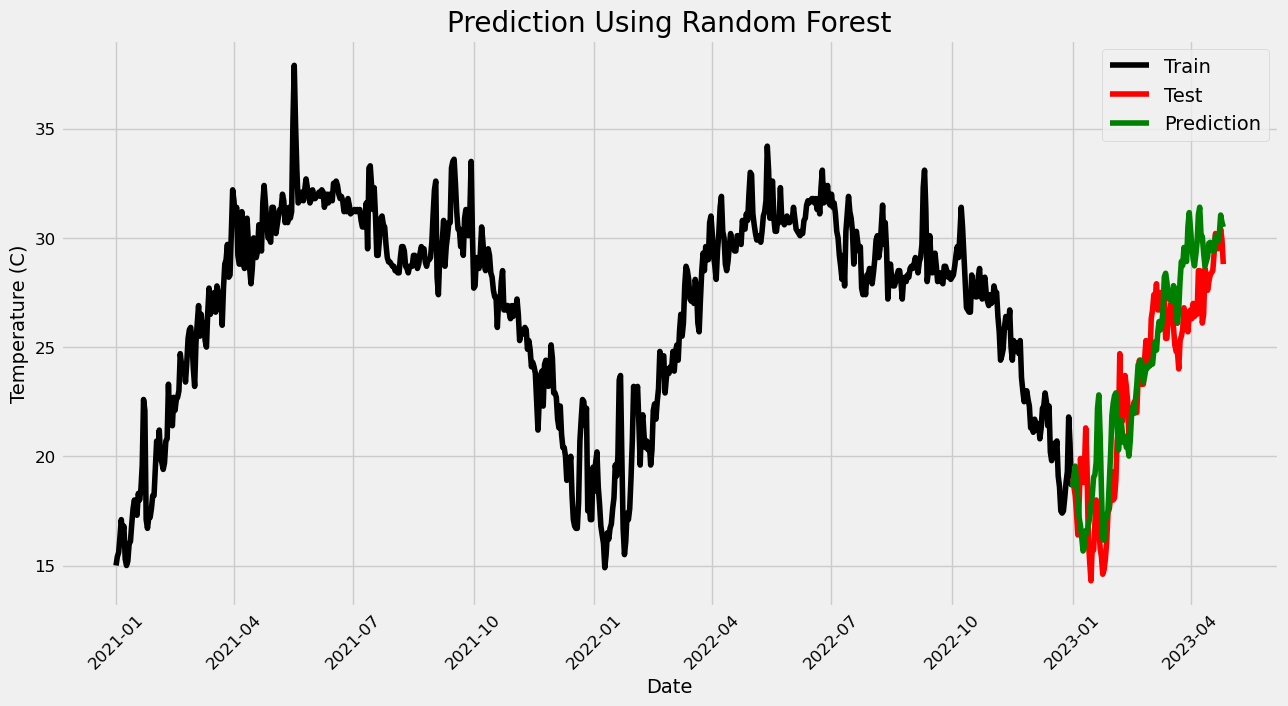

RMSE:  2.316867982859616


In [134]:
from sklearn.ensemble import RandomForestRegressor

# fit the model
rfmodel = RandomForestRegressor()
rfmodel.fit(X, Y)

# predict on the same period
preds = rfmodel.predict(testX)

# plot what has been learned
plt.figure(figsize=(14, 7))
plt.plot(train.index, train.values, color="black", label='Train')  
plt.plot(test.index, test.values, color="red", label='Test')
plt.plot(test.index, preds, color="green", label='Prediction')
plt.ylabel('Temperature (C)')
plt.xlabel('Date')
plt.title("Prediction Using Random Forest")
plt.legend()
plt.xticks(rotation=45)
plt.show()
rf = pd.DataFrame({'Datetime': test.index, 'Predicted_Temperature': preds, 'Algorithm': 'RandomForest'})
rf_rmse = np.sqrt(mean_squared_error(test.values, preds))
print("RMSE: ", rf_rmse)

##### **^Explanation/Reasoning:** The close alignment of the green prediction line with the red test data and the low RMSE of roughly 2.32 demonstrate the Random Forest model's strong predictive performance. This implies that the model produces accurate short-term projections by successfully capturing the patterns and fluctuations in the temperature data.

##### **Regressor Technique 2:** 


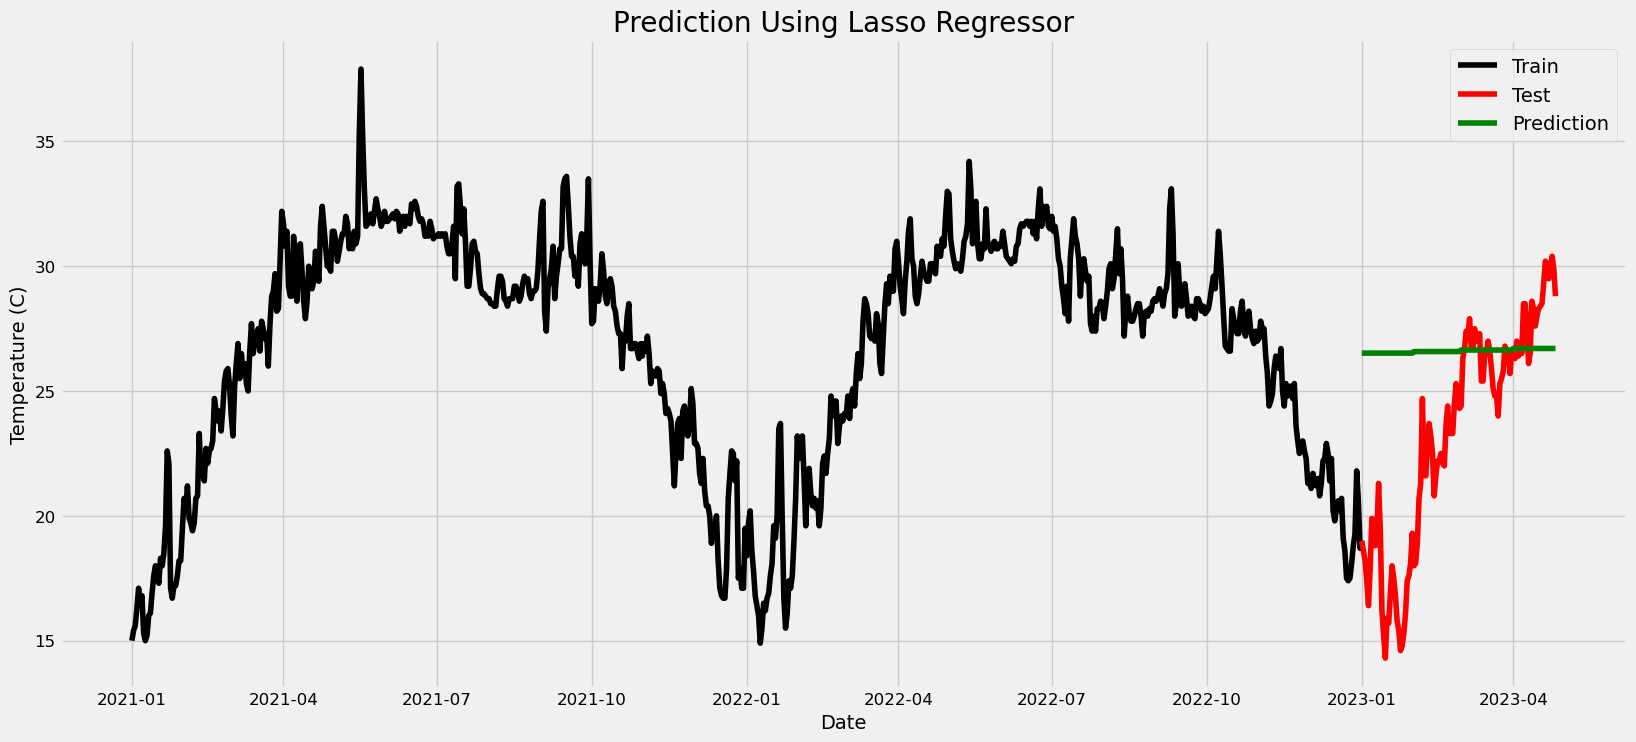

RMSE:  5.447953013995037


In [145]:
from sklearn.linear_model import Lasso
 
# fit the model
lassoModel = Lasso()
lassoModel.fit(X,Y)
 
# predict on the same period
preds = lassoModel.predict(testX)
 
# plot what has been learned
plt.plot(train.index, train.values,color="black", label='Train')
plt.plot(test.index, test.values,color="red", label='Test')
plt.plot(test.index, preds, color="green",label='Prediction')
plt.legend()
plt.ylabel('Temperature (C)')
plt.xlabel('Date')
plt.title("Prediction Using Lasso Regressor")
plt.show()
lr = pd.DataFrame({'Datetime': test.index,'Predicted_Temperature': preds, 'Algorithm': 'LassoRegressor'})

df3 = pd.merge(results_df, sar_df, on=['Datetime', 'Algorithm', 'Predicted_Temperature'], how='outer')
df3 = pd.merge(df3, rf, on=['Datetime', 'Algorithm', 'Predicted_Temperature'], how='outer')
df3 = pd.merge(df3, lr, on=['Datetime', 'Algorithm', 'Predicted_Temperature'], how='outer')
df3['Datetime'] = pd.to_datetime(df3['Datetime']).dt.strftime('%Y-%m-%d')

rf_rmse = np.sqrt(mean_squared_error(test.values, preds))
print("RMSE: ",rf_rmse)

##### **^Explanation/Reasoning:** The Lasso Regressor model has trouble accurately capturing the seasonal and trend fluctuations, as evidenced by the limited alignment between its predictions (green line) and the test data (red line). The greater RMSE of roughly 5.45, which indicates that the model might be underfitting and insufficiently sophisticated for this dataset, lends additional credence to this.

## Q8

##### The RMSE of ARIMA and SARIMA are 3.06 and 5.91 respectively. While the RMSE of two regression algorithm (1) Random Forest Regressor is 2.32 and (2) Lasso Regressor is 5.45. With an RMSE of **2.32**, the **Random Forest Regressor** is the best-performing model, demonstrating its great ability to identify seasonality and non-linear trends in the data. With an RMSE of **3.06**, **ARIMA** comes next, demonstrating strong predictive ability but lower accuracy than Random Forest. With RMSEs of **5.91** and **5.45**, respectively, **SARIMA** and **Lasso Regressor** perform worse, indicating challenges in modelling seasonality and complex patterns. In this instance, **Random Forest** is the best option for precise temperature forecasts.



## Q9

In [155]:
futureX = pd.date_range(start='11/01/2024', end='12/31/2024')
futureX

DatetimeIndex(['2024-11-01', '2024-11-02', '2024-11-03', '2024-11-04',
               '2024-11-05', '2024-11-06', '2024-11-07', '2024-11-08',
               '2024-11-09', '2024-11-10', '2024-11-11', '2024-11-12',
               '2024-11-13', '2024-11-14', '2024-11-15', '2024-11-16',
               '2024-11-17', '2024-11-18', '2024-11-19', '2024-11-20',
               '2024-11-21', '2024-11-22', '2024-11-23', '2024-11-24',
               '2024-11-25', '2024-11-26', '2024-11-27', '2024-11-28',
               '2024-11-29', '2024-11-30', '2024-12-01', '2024-12-02',
               '2024-12-03', '2024-12-04', '2024-12-05', '2024-12-06',
               '2024-12-07', '2024-12-08', '2024-12-09', '2024-12-10',
               '2024-12-11', '2024-12-12', '2024-12-13', '2024-12-14',
               '2024-12-15', '2024-12-16', '2024-12-17', '2024-12-18',
               '2024-12-19', '2024-12-20', '2024-12-21', '2024-12-22',
               '2024-12-23', '2024-12-24', '2024-12-25', '2024-12-26',
      

Forecasted Temperatures from November 1, 2024, to December 31, 2024:
2024-11-01    18.946935
2024-11-02    18.841571
2024-11-03    19.024747
2024-11-04    19.089728
2024-11-05    19.401503
                ...    
2024-12-27    23.878599
2024-12-28    23.822679
2024-12-29    23.861439
2024-12-30    23.931992
2024-12-31    23.872888
Freq: D, Name: Predictions, Length: 61, dtype: float64


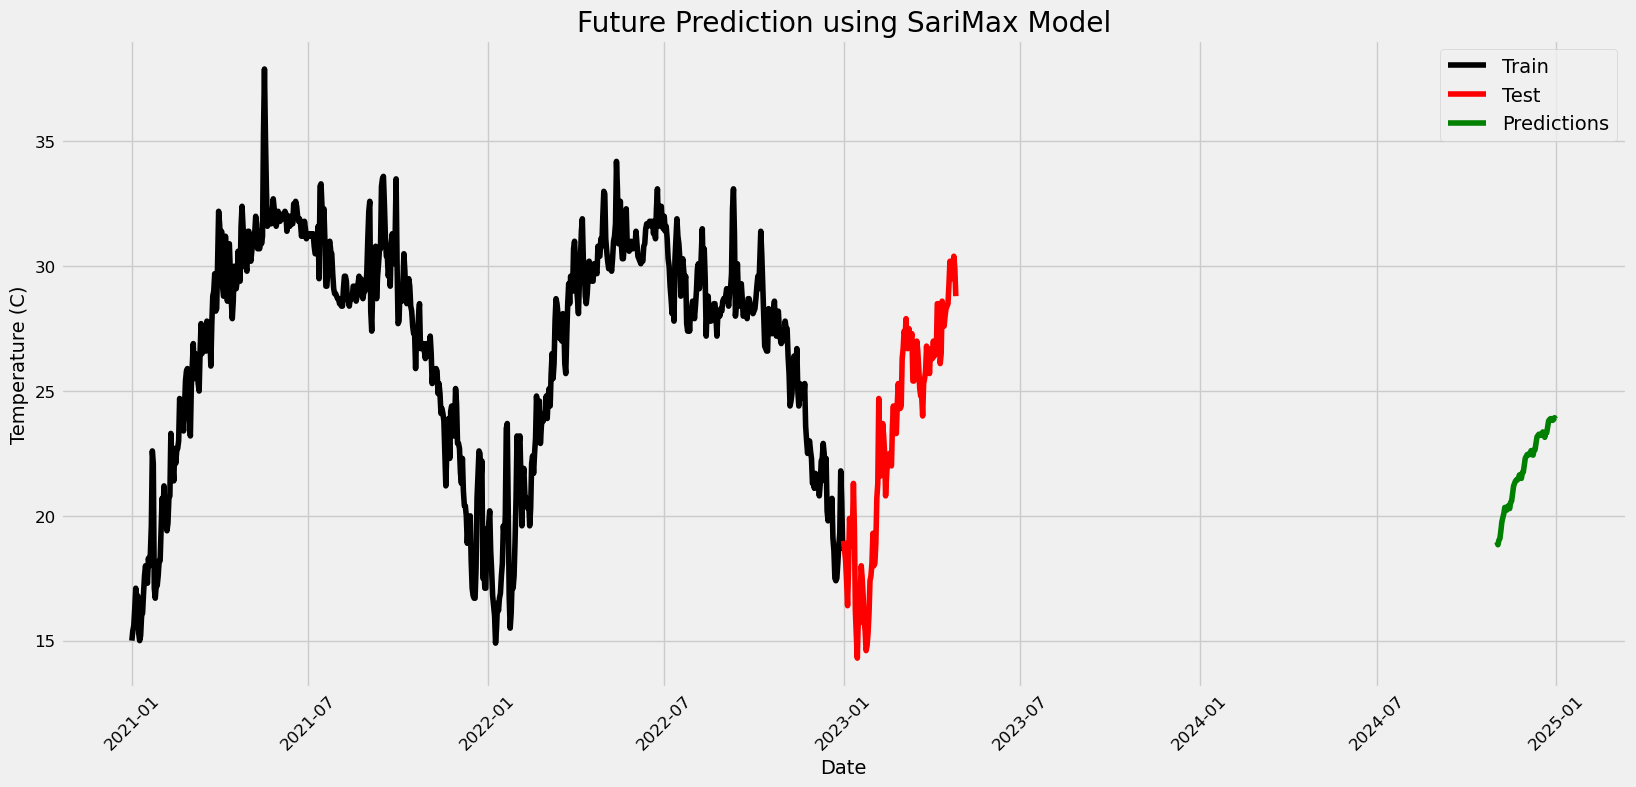

In [163]:
SARIMAXmodelNew = SARIMAX(train, order=(1,0,1),seasonal_order=(1, 1, 1, 12))
SARIMAXmodelNew = SARIMAXmodelNew.fit()

#Train set prediction
y_pred = SARIMAXmodel.get_forecast(len(futureX))
y_pred_df = y_pred.conf_int(alpha=0.45)
y_pred_df["Predictions"] = SARIMAXmodel.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])

#for training prediction plotting purposes
y_pred_df.index = futureX
y_pred_out = y_pred_df["Predictions"]

print("Forecasted Temperatures from November 1, 2024, to December 31, 2024:")
print(y_pred_out)

plt.plot(train, color="black", label='Train')
plt.plot(test, color="red", label='Test')
plt.ylabel('Temperature (C)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Future Prediction using SariMax Model")

plt.plot(y_pred_out, color='green', label='Predictions')
plt.legend()
plt.show()

##### **^Explanation/Reasoning:** An expected rise in temperature is indicated by the SARIMAX model's future prediction from November to December 2024 (green line), which displays a consistent upward trend. Although its accuracy needs be checked against real future data for validation, this output shows that the model can predict future seasonal behaviour.

## Q10

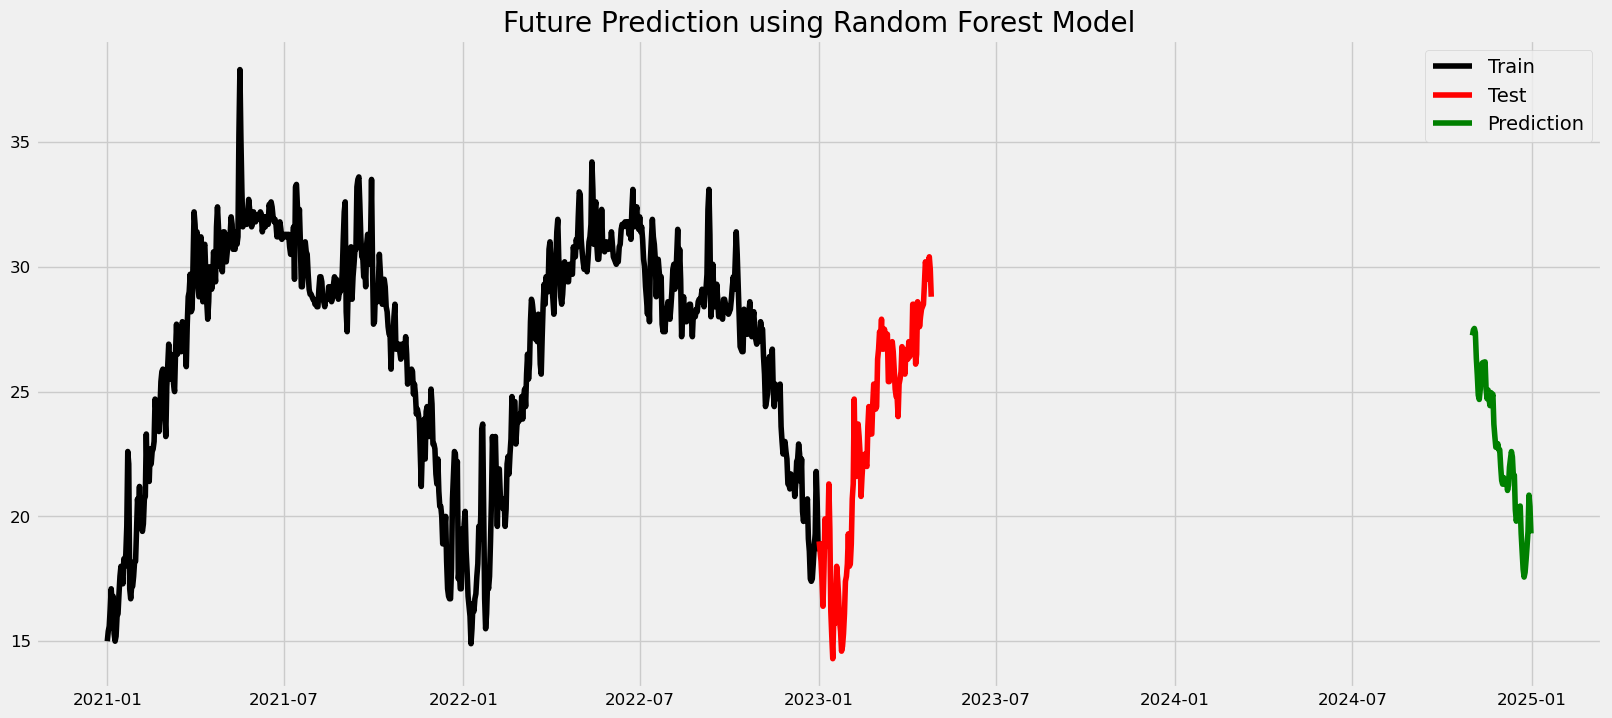

In [165]:
from sklearn.ensemble import RandomForestRegressor

futureX = pd.date_range(start='11/01/2024', end='12/31/2024')

# extract the seasonality data
tmonths = [x.month for x in futureX]
tyears = [x.year for x in futureX]
tday = [x.day for x in futureX]

# convert into one matrix
testX = np.array([tday, tmonths, tyears]).T

# fit the model
rfmodel = RandomForestRegressor()
rfmodel.fit(X, Y)

# predict on the same period
preds = rfmodel.predict(testX)

# plot what has been learned
plt.plot(train.index, train.values, color="black", label='Train')
plt.plot(test.index, test.values, color="red", label='Test')
plt.plot(futureX, preds, color="green", label='Prediction')
plt.title("Future Prediction using Random Forest Model")
plt.legend()
plt.show()

##### **^Explanation/Reasoning:** In contrast to the outcomes of the SARIMAX model, the Random Forest model's future prediction (green line) for November through December 2024 displays a negative trend. This draws attention to the model's perhaps inconsistent interpretation of seasonal elements and suggests that additional research or cross-validation is required to evaluate the model's dependability for upcoming forecasts.

## Q11

##### Based on seasonal warming patterns, the **SARIMAX model** forecasts an increase in temperature from November to December 2024. However, a decreasing trend is predicted by the **Random Forest model**, suggesting a different interpretation of the patterns in the data. This implies that Random Forest may catch non-linear interactions but may misread seasonal trends, whereas SARIMAX is better at capturing seasonal cycles. To verify which model is more correct, validation using subsequent data is required.

